# Preparation

In [15]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
# Import data
item_categories = pd.read_csv('data/item_categories.csv')
items = pd.read_csv('data/items.csv')
sales_train = pd.read_csv('data/sales_train.csv', parse_dates=['date'], dayfirst=True)
sample_submission = pd.read_csv('data/sample_submission.csv')
shops = pd.read_csv('data/shops.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# Augment data
sales_train['month'] = sales_train['date'].dt.month
sales_train['year'] = sales_train['date'].dt.year
sales_train['weekday'] = sales_train['date'].dt.day_of_week + 1
sales_train['total_price'] = sales_train['item_cnt_day'] * sales_train['item_price']
sales_train = pd.merge(sales_train, items[['item_id', 'item_category_id']], on='item_id')

In [4]:
# Standardization function necessary for the count matrices
def standardize(matrix, cols=True, rows=True):
    if cols:
        col_mean = matrix.mean(axis=0)
        col_std = matrix.std(axis=0)
        matrix = (matrix - col_mean[np.newaxis, :]) / col_std[np.newaxis, :]
        matrix = np.nan_to_num(matrix)
    if rows:
        row_mean = matrix.mean(axis=1)
        row_std = matrix.std(axis=1)
        matrix = (matrix - row_mean[:, np.newaxis]) / row_std[:, np.newaxis]
        matrix = np.nan_to_num(matrix)
    return matrix

## Generating the count matrices
Note: U don't need to run this part! The next part will load stored versions of these matrices.

In [ ]:
shop_itemcat = sales_train.groupby(['shop_id', 'item_id'], as_index=False).sum()
mat = np.zeros((60, 22170))
for i in tqdm(range(60)):
    for j in range(22170):
        total_cnt = shop_itemcat[(shop_itemcat['shop_id']==i) & (shop_itemcat['item_id']==j)]['item_cnt_day']
        if not total_cnt.empty:
            mat[i,j] = total_cnt

np.save('shopitem.npy', mat)

In [ ]:
shop_itemcat = sales_train.groupby(['month', 'item_id'], as_index=False).sum()
mat = np.zeros((12, 22170))
for i in tqdm(range(12)):
    for j in range(22170):
        total_cnt = shop_itemcat[(shop_itemcat['month']==i+1) & (shop_itemcat['item_id']==j)]['item_cnt_day']
        if not total_cnt.empty:
            mat[i,j] = total_cnt

np.save('monthitem.npy', mat)

In [ ]:
shop_itemcat = sales_train.groupby(['month', 'shop_id'], as_index=False).sum()
mat = np.zeros((12, 60))
for i in tqdm(range(12)):
    for j in range(60):
        total_cnt = shop_itemcat[(shop_itemcat['month']==i+1) & (shop_itemcat['shop_id']==j)]['item_cnt_day']
        if not total_cnt.empty:
            mat[i,j] = total_cnt

np.save('monthshop.npy', mat)

(-12.0, 19934.0)


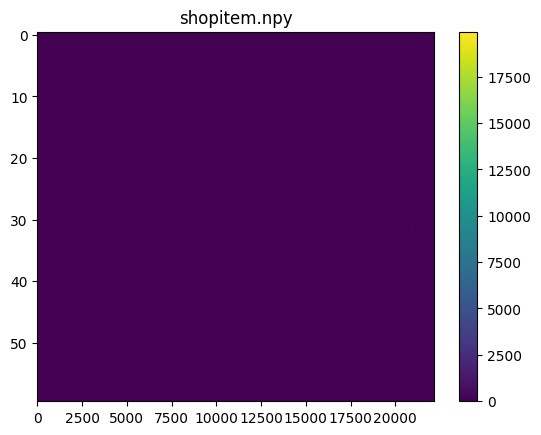

c:\Users\luukr\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


(-7.681145747868605, 7.681145747868624)


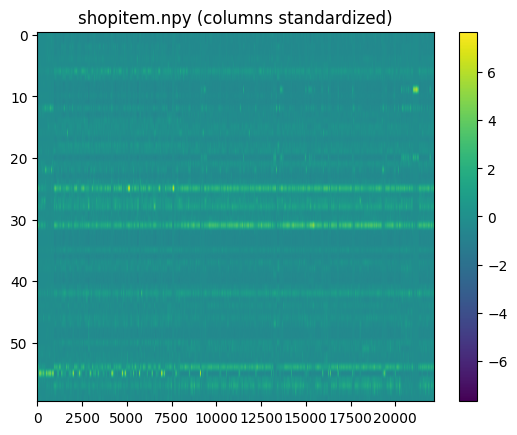

(-0.592448168598409, 144.2062932692594)


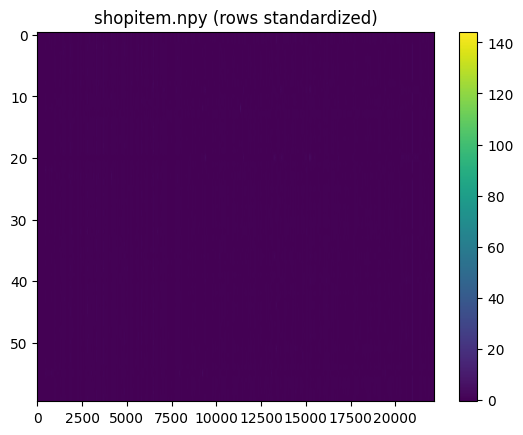

(-9.92316384138757, 27.13932181353482)


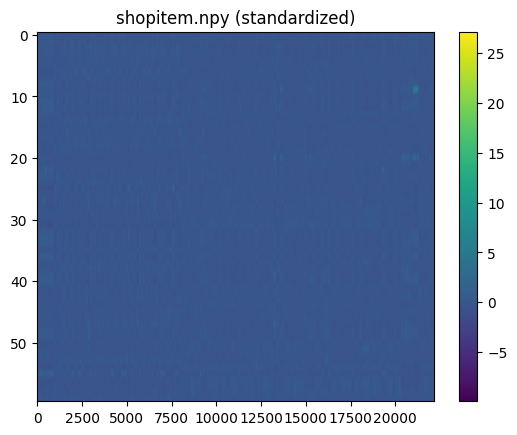

(-22.0, 24742.0)


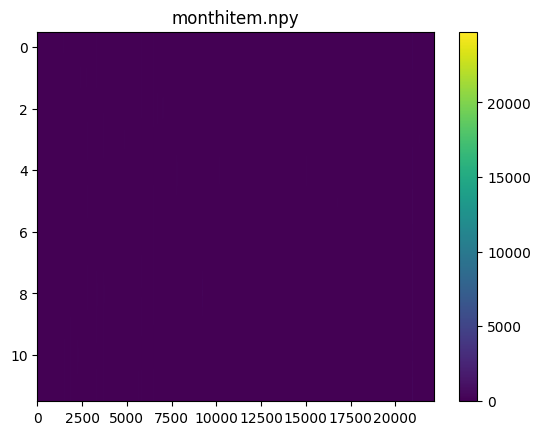

(-3.3166247903554007, 3.3166247903554007)


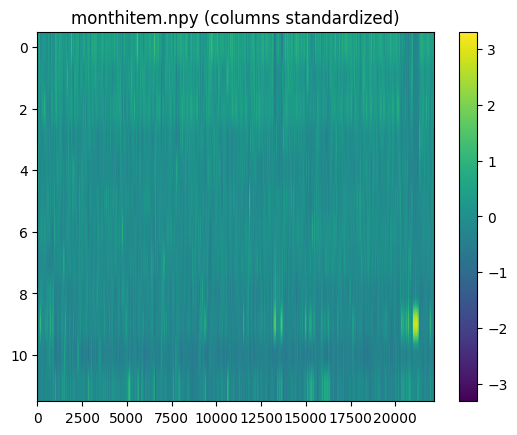

(-0.38615303298319714, 139.028821441992)


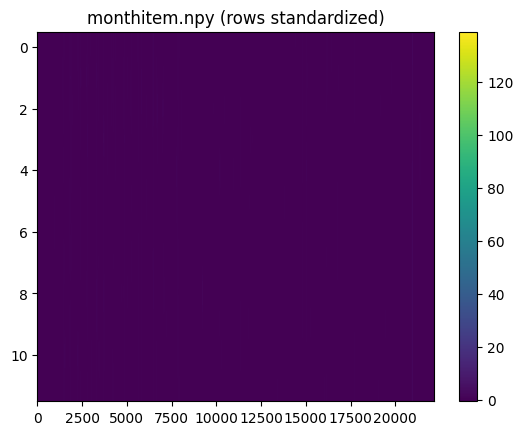

(-3.69811925013162, 4.477145585274025)


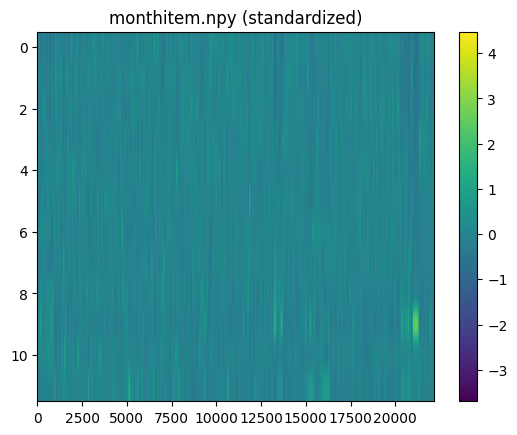

(-1.0, 30928.0)


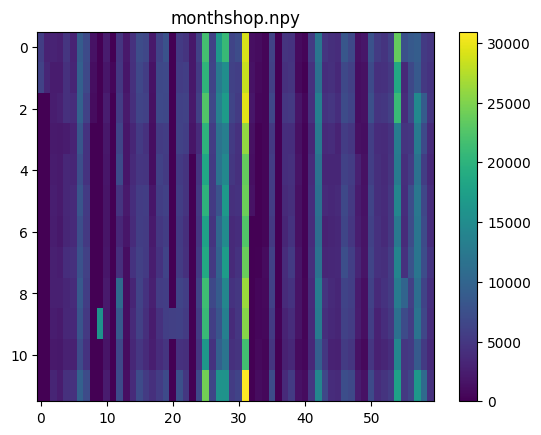

(-2.240427731485418, 3.3166247903554)


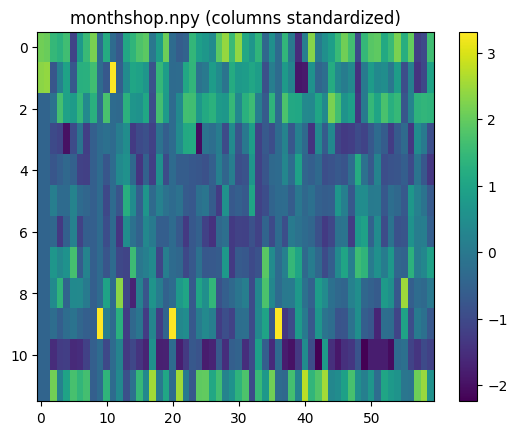

(-1.066855465171776, 4.557831200682385)


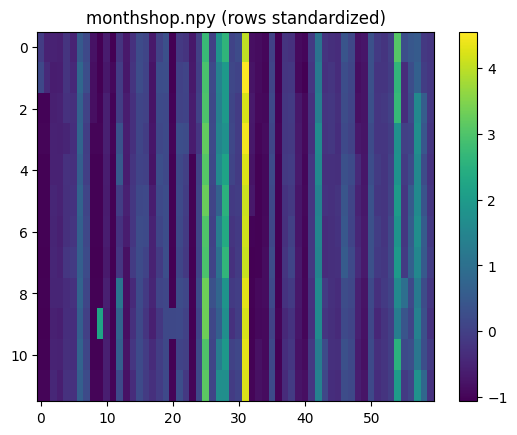

(-2.629169573282132, 3.4415799609819087)


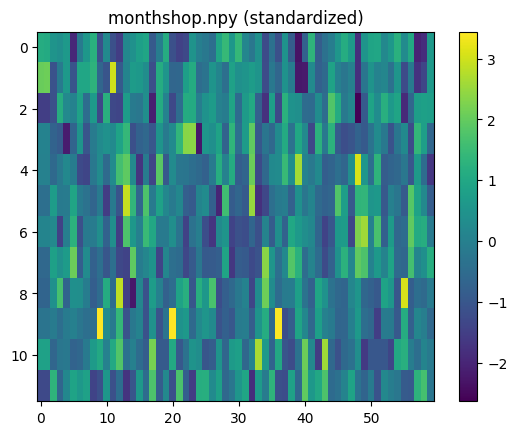

In [5]:
for file in ['shopitem.npy', 'monthitem.npy', 'monthshop.npy']:
    mat = np.load(file)
    settings = [[False, False, ''], 
                [False, True, ' (columns standardized)'], 
                [True, False, ' (rows standardized)'], 
                [True, True, ' (standardized)']]

    for setting in settings:
        stand = standardize(mat.copy(), rows=setting[0], cols=setting[1])
        fig = plt.imshow(stand, aspect='auto', vmin=np.min(stand), vmax=np.max(stand)) # Can also visualize selection of stand
        plt.title(file + setting[2])
        plt.colorbar()
        plt.show()

## Calculating simple means

In [5]:
mean_per_item = sales_train.groupby(['item_id'], as_index=False).mean()
mean_per_shop = sales_train.groupby(['shop_id'], as_index=False).mean()
mean_per_month = sales_train.groupby(['month'], as_index=False).mean()
mean_per_year = sales_train.groupby(['year'], as_index=False).mean()

mean_item_cnt = np.zeros((22170))
mean_item_price = np.zeros((22170))
for item in range(22170):
    mean_item = mean_per_item[mean_per_item['item_id'] == item]
    if not mean_item.empty:
        mean_item_cnt[item] = mean_item['item_cnt_day']
        mean_item_price[item] = mean_item['item_price']

mean_month_cnt = np.zeros((12))
mean_month_price = np.zeros((12))
for month in range(12):
    mean_month_cnt[month] = mean_per_month[mean_per_month['month'] == month+1]['item_cnt_day']
    mean_month_price[month] = mean_per_month[mean_per_month['month'] == month+1]['item_price']

mean_shop_cnt = np.zeros((60))
mean_shop_price = np.zeros((60))
for shop in range(60):
    mean_shop_cnt[shop] = mean_per_shop[mean_per_shop['shop_id'] == shop]['item_cnt_day']
    mean_shop_price[shop] = mean_per_shop[mean_per_shop['shop_id'] == shop]['item_price']

mean_year_cnt = np.zeros((3))
mean_year_price = np.zeros((3))
for year in range(3):
    mean_year_cnt[year] = mean_per_year[mean_per_year['year'] == year + 2013]['item_cnt_day']
    mean_year_price[year] = mean_per_year[mean_per_year['year'] == year + 2013]['item_price']

## Creating data matrix

In [6]:
monthly = sales_train.groupby(['shop_id', 'month', 'item_id'], as_index=False).first() # NOTE we don't actually use the rest of the monthly data. We only use the groups. And the year. 

# Note we could also add itemcategory
shop_item = np.load('shopitem.npy')
month_item = np.load('monthitem.npy')
month_shop = np.load('monthshop.npy')
stand_shop_item = standardize(shop_item.copy())
stand_month_item = standardize(month_item.copy())
stand_month_shop = standardize(month_shop.copy())

def create_data_matrix(input_df, month=None, year=None):
    
    data_matrix = np.zeros((input_df.shape[0], 14))

    for index, row in tqdm(input_df.iterrows()):

        shop = int(row['shop_id'])
        item = int(row['item_id'])
        if month is None:
            month = int(row['month'])
            year = int(row['year']) - 2013

        data_matrix[index, 0] = shop_item[shop, item]
        data_matrix[index, 1] = stand_shop_item[shop, item]
        data_matrix[index, 2] = month_item[month-1, item]
        data_matrix[index, 3] = stand_month_item[month-1, item]
        data_matrix[index, 4] = month_shop[month-1, shop]
        data_matrix[index, 5] = stand_month_shop[month-1, shop]
        data_matrix[index, 6] = mean_item_cnt[item]
        data_matrix[index, 7] = mean_item_price[item]
        data_matrix[index, 8] = mean_month_cnt[month-1]
        data_matrix[index, 9] = mean_month_price[month-1]
        data_matrix[index, 10] = mean_shop_cnt[shop]
        data_matrix[index, 11] = mean_shop_price[shop]
        data_matrix[index, 12] = mean_year_cnt[year]
        data_matrix[index, 13] = mean_year_price[year]

    return data_matrix
    

c:\Users\luukr\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


# Applying the model

In [7]:
X = create_data_matrix(monthly)
y = monthly['item_cnt_day']

1396971it [03:01, 7710.11it/s] 


In [8]:
scaler = StandardScaler()
scaler.fit_transform(X)

c:\Users\luukr\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\preprocessing\_data.py:948: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


array([[-3.23319694e-02, -7.14186799e-01,  1.04642420e+00, ...,
        -2.02329688e+00, -1.80402360e-11, -1.77262791e-08],
       [-1.14888661e-01, -9.08117158e-01,  1.49835659e-01, ...,
        -2.02329688e+00, -1.80402360e-11, -1.77262791e-08],
       [-4.05876386e-02,  2.23897659e+00,  1.96379824e-02, ...,
        -2.02329688e+00, -1.80402360e-11, -1.77262791e-08],
       ...,
       [ 1.57548421e-01,  1.00924956e+00,  1.73507964e-01, ...,
        -7.42310710e-02, -1.80402360e-11, -1.77262791e-08],
       [ 5.37309201e-01,  1.53366408e+00,  7.29807126e-01, ...,
        -7.42310710e-02, -1.80402360e-11, -1.77262791e-08],
       [-1.31399999e-01, -8.09708488e-01,  8.17777825e-02, ...,
        -7.42310710e-02, -1.80402360e-11, -1.77262791e-08]])

In [14]:
# Testing using train-test split
model = SGDRegressor()
# model = RandomForestRegressor()

repetitions = 10
train_rmse, test_rmse = 0,0
for i in range(repetitions):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    train_rmse += np.sqrt(mean_squared_error(y_train, y_train_predict))
    y_predict = model.predict(X_test)
    test_rmse += np.sqrt(mean_squared_error(y_test, y_predict))

print('Train RMSE:', train_rmse/repetitions)
print('Test RMSE:', test_rmse/repetitions)

Train RMSE: 1.1721193353930377
Test RMSE: 1.6306504164057984


In [28]:
# Making a submission
model = RandomForestRegressor()
model.fit(X, y)
X_real_test = pd.read_csv("data/test.csv")
X_real_test = create_data_matrix(X_real_test, month=11, year=2015-2013)
scaler.transform(X_real_test)
y_test = model.predict(X_real_test)
submission_df = pd.DataFrame()
submission_df['ID'] = pd.read_csv("data/test.csv")['ID']
submission_df['item_cnt_month'] = y_test
submission_df.to_csv('submission.csv', index=False)

214200it [00:16, 12697.32it/s]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [30]:
submission_df['ID'] = pd.read_csv("data/test.csv")['ID']
submission_df['item_cnt_month'] = y_test
submission_df.to_csv('submission.csv', index=False)